## 11-30-2020 <div style="position:relative; float:right"><img style="height:135px" src ="top-header.jpg" />
</div>
</div>

# FUNDAMENTALS OF A\B TESTING IN PYTHON

## ALEX MAZZARELLA



<div style="text-align: right"> image credit: crazyegg.com</div>

# =============================================================

## INTRODUCTION

The purpose of this notebook, is to evaluate the results of an A/B testing in Python.
It is a very simple task, yet a very common practice in many fields.

In the notebook, I will show the steps and considerations to perform such test, often referring to the basic statistical concepts behind the tests.
We will approach an example of Continuous data and one of Categorical data.

In [1]:
# IMPORT PACKAGES AND LIBRARIES

import pandas as pd
import numpy as np
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns

import random
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm, sem, ttest_ind
from statistics import variance

# ==========================================================

## EXAMPLE 1: CONTINUOUS DATA

Let's say that our Web Development team, has recently redesigned our app that helps users reduce their weekly screen time.
They have a budget meeting in 2 months and they want to know by that time, if the new designs will be bringing actual improvements or if further implementations are needed.

As Data Scientists, our task is to figure out if the users have actually increased the off-screen time with the new app design. 
The team has already run a test and provides us with data to be analyzed.

* They have conducted the test on 2,000 newly signed-up users, over a 2 weeks usage time.
* 1,000 have used the app current design: we will refer to them as `group_a` (the control group). 
* The other 1,000 have used the redesigned version: these will be `group_b` (experimental group).

We know that the app has been launched about a year ago, and has currently ~ 100,000 users.

The data shows that after the two weeks test, users from group a have increased their off-screen time by 16%. Group b by 17%. The standard deviation is equal for both at 5%.

(Note: for the purpose of this notebook, we are actually going to generate the data here).

In [2]:
# setting container for random number generator
rand_st = RandomState(17)

In [3]:
# function that we use to generate the results of the 2 groups

def generateGroupsResults (sample_size, mean_a, mean_b, stdev):
    """
    Generates 2 numpy lists containing random float numbers.List size, mean and standard deviation are given through parameters.
    
    INPUT:
    - sample_size: (the total, will be then split in two groups of identical size)
    - mean_a: mean of group a
    - mean_b: mean of group b
    - stdev: standard deviation (same for both groups)
    
    OUTPUT: 
    - distribution of results for the two groups
    """
    
    assert (sample_size % 2 == 0) & (type(sample_size)==int), "Sample size must be an even integer"
    
    # group a - control 
    group_a = []
    [group_a.append(rand_st.randn()*stdev + mean_a) for i in range(sample_size//2)]

    # group b - experimental
    group_b = []
    [group_b.append(rand_st.randn()*stdev + mean_b) for i in range(sample_size//2)]
    
    return group_a, group_b

In [4]:
# generating results of groups a and b
group_a, group_b = generateGroupsResults(2000, 0.16, 0.17, 0.05)

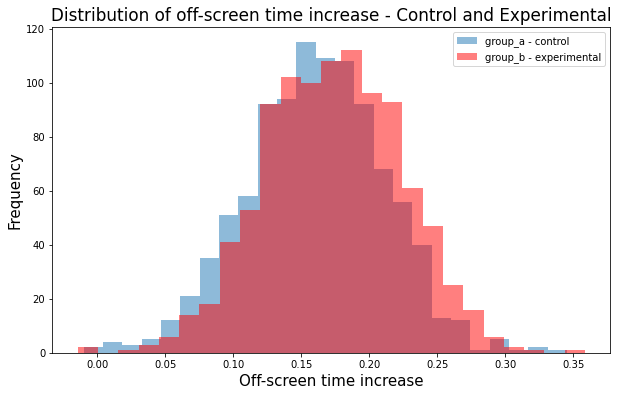

In [5]:
# plotting distributions of results for group a and group b

fsize = 15

plt.figure(figsize=(10,6))
plt.hist(group_a,  bins=25, alpha = 0.5, label='group_a - control');
plt.hist(group_b, bins=25, alpha = 0.5, color = 'red', label='group_b - experimental');

plt.xlabel("Off-screen time increase",fontsize=fsize)
plt.ylabel("Frequency",fontsize=fsize)
plt.title('Distribution of off-screen time increase - Control and Experimental', fontsize = fsize*1.12)
plt.legend()


plt.show()

What we observe both from the numbers and the visualization, is that the users of `group_b`, have a higher increase in the off-screen time.
The difference that we see in the two proportions (17% - 16% = 1%) is called **lift**.

Therefore, we can conclude that the new design brings better performances, right? Not quite.

We can still not be sure that the difference is due only to the new design.
Perhaps, the new design does not increase the actual effectiveness of the app, but the users sampled in the experimental group were just more likely to reduce their screen time.
So how can we confirm that the results obtained are not due to random chance?

In order to address such concern, we will run an **hypothesis test**.

We mentioned that we are not (yet) able to exclude that the new design might not be as effective as the example above shows.
We only selected a random sample of 2,000 individuals and the total amount of users is 100,000+.
It is very likely that, if we were to select another random sample of 2,000 individuals, the respective group averages would have been (slightly) different.
This would be true for any sample of the population.

With that in mind, the question for us at this point is: what is the likelihood that the increase in off-screen time observed
is due to random chance?

With the information above, we are now ready to formulate our null and alternative hypotheses!

**Hypothesis Test:**

$H_0$: The increase in off-screen time with the new design is equal to the increase with the former. 



<left> $H_1$: The increase with the new design is different.

Let's quickly list the *general assumptions* of our two samples (unpaired) t-Test

- The data points in group a are independent from those in group B
- The data points in each group are independent of each other 
- Standard Deviation (and variance) of the two groups are identical
- The means of both groups come from a normal distribution. This means that either:
    - The sampled groups are large enough that the Central Limit Theorem guarantees distributions of the samples are approximately normal
    - The samples are normally distributed (the populations are normally distributed).
    
Note: in our example, we are dealing with a *two-tailed* t-test.
Should you benefit from a quick explanation of the differences between one and two tailed t-tests, please [check this page](https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/one-tailed-test-or-two/).

As anticipated, since the scope of this notebook is to provide an example of AB test, we will not dive too deep in statistical theory.
However, an important (relatively simple) formula to remeber is the one of the t-statistic

$$ t = \frac{(\overline{X}_1 - \overline{X}_2) - (\mu_1 - \mu_2)}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}$$

Where:
* $\overline{X}_1$ and $\overline{X}_2$ are the samples means,
* $(\mu_1 - \mu_2)$ is the population difference we are going to test against and 
* $s_1$ & $s_2$ are the standard deviations of the two groups. 

Therefore, to apply it in our little experiment:

$$ t = \frac{(\overline{X}_{new\_design} - \overline{X}_{current\_design}) - 0}{\sqrt{\frac{s_1^2}{100}+\frac{s_2^2}{100}}}$$


Now, back to our calculations.

First, we define the alpha value. 
In hypothesis testing, alpha is a "cutoff" for the p-value.

Remember, in general the p-value quantifies the probability of seeing the observed data given that the null hypothesis is true.
So basically, if the p-value that we will calculate is equal or greater than alpha, we fail to reject the null hypothesis; we reject it instead if it is lesser than that.

As the most commonly used in statistics is 5%, that is what we will use here.

In [6]:
#initializing the value of alpha 
alpha = 0.05

Now the alpha value is set, we proceed to calculate the test statistics and the p-value.
For both of them, the module *stats* of the library *scipy* provides us already with a function to calculate them both in just one line of code! You can check the documentation [here](https://docs.scipy.org/doc/scipy/reference/stats.html).

In [7]:
# calculating t-statistic and p-value with ttest_ind function
t_stat,p_val = ttest_ind(group_a,group_b)

In [8]:
# printing results

print(f'The t-statistic is {t_stat:0.6f}\nThe p-value is {p_val}\n')
if p_val< alpha:
    print(f'Since the calculated p-value is below {alpha}, we reject the null hypothesis.')
else:
    print(f'Since the calculated p-value is above {alpha}, we fail to reject the null hypothesis.')

The t-statistic is -5.398606
The p-value is 7.5150497755254e-08

Since the calculated p-value is below 0.05, we reject the null hypothesis.


To recap, we had observed that users from group b (new app design) had an average additional off-screen time of 17% versus the 16% of the group a (current design).
We had therefore a lift of 1% and wanted to understand if the results are due to random chance or not.

Finally, since our calculated p-value is lesser than alpha, we can reject the null hypothesis and confirm that our results are statistically significant.
The p-value is 0.000710, which means that there is a ~0.07% probability of observing the results we obtained due to random chance.
(Or, the probability of observing the results obtained, if or null hypothesis was true).

All that is left to do now, is giving the good news to the web development team, and tell them that the new design is leading to higher performances!

# ==============================================

## EXAMPLE 2: CATEGORICAL DATA

As the previous example was using a continuous variable (% of off-screen time increase), we will also run a quick example with a categorical value.

We work at a softwar firm that creates online education platforms.
We are approaching the year end holidays and soon we will offer a new promotion to existing clients, on the upgrade to our premium tier subscription.
Our marketing and UX team have designed two different emails (A and B) for the promotion. These are identical, except for the subject. We are in charge of letting them know which one will deliver better results.


After sending the emails to a randomly extracted sample from our clients' database, we record the email open rate.

(Once again, for the only purpose of demonstrating the calculation, we will generate data here).


In [9]:
#function used to generate binary distribution with given ration of 1 and 0

def random_bin_array(prob_1, size = 100):
    """
    Generates a Numpy array of binary values (1,0) with the size and probability of 1 requested.
    
    INPUT:
    - probability of values '1' in the array. If it is not possible to represent the exact ratio requested,
        the count of 1 will be rounded to the lower int
    - size of the array
    
    OUTPUT:
    - array of binary values
    """
    
    assert (prob_1 >0) & (prob_1 <=1) & (type(prob_1)==float), 'prob_1 must be a float value between 0 and 1' 
    assert (size > 10) & (type(size)==int), 'size of the array requested must be an integer > 10'
    arr = np.zeros(size, dtype = int)
    arr[:int(size*prob_1)]  = 1
    np.random.shuffle(arr)
    return arr

In [10]:
# creating test results for our example

sample_size = 2000
open_rate_a = 0.199
open_rate_b = 0.208


group_a = random_bin_array(open_rate_a, sample_size//2)

group_b = random_bin_array(open_rate_b, sample_size//2)

In [11]:
print(f'Email open rate of group A ==> {(np.mean(group_a)*100):.2f} %')
print(f'Email open rate of group B ==> {(np.mean(group_b)*100):.2f} %')

Email open rate of group A ==> 19.90 %
Email open rate of group B ==> 20.80 %


The results show us that the email sent to the group B, has brought a higher open rate. The lift here is 0.9%.

But once again, how can we exclude that this could be due to random chance, and that the version of the email sent to group B will actually bring different results from the other?

In our specific case, we can quickly run a proportions z-test.

What we are going to test here, is if there is a statistically significant difference between the open rate with email version A, and that with email version B.
 
Therefore:
* $p_A$ = open rate with email version A
* $p_B$ = open rate with email version B
* $d = p_A - p_B$

When we take differences of proportions (i.e. email open rate in our example), **d** is normally distributed.
Once again, since the scope of this notebook is to show two examples of AB testing in Python, I won't go in detail explaining this point, but please feel free to [check this page](https://stattrek.com/hypothesis-test/difference-in-proportions.aspx) for a demonstration.

Given the above considerations, we are ready to draw our null and alternative hypotheses:

$$ H_0 : d = 0 \; \; \; \text{vs}\; \; \; H_1 : d \neq 0 $$


Let's calculate then the z-test statistic and p-value for our data!

In [12]:
# Z STAT calculation

alpha = 0.05

# counts are the number of successes in nobs trials.
# In our case it is represented by the number of emails opened
counts = [group_a.sum(), group_b.sum()]

# nobs are the number of observations.
# in our example, the total clients (per group) to whom the email was sent
nobs = [len(group_a), len(group_b)]

# z_test
zstat, p_val = proportions_ztest(counts,nobs)

In [13]:
# printing the results

print(f'The z-stat is {zstat:0.6f}\nThe p-value is {p_val:0.6f}\n')

if p_val< alpha:
    print(f'Since the calculated p-value is below {alpha}, we reject the null hypothesis.')
else:
    print(f'Since the calculated p-value is above {alpha}, we fail to reject the null hypothesis.')

The z-stat is -0.499865
The p-value is 0.617170

Since the calculated p-value is above 0.05, we fail to reject the null hypothesis.


What the results tell us, is that there is not enough statistical evidence to conclude that the two email may bring to different open rates.
There is over 61% probability that open rates differences obtained during our test, are due to random chance.

At this point, because our time values a "continuous improvement" approach, and we still have time and budget available for a new test, we decide to try a new modified version of email b.

We randomly select another sample of clients, and repeat the experiment.

(This is the last time that I am going to generate random data in this notebook, I promise.)

In [14]:
sample_size = 2000
open_rate_a = 0.203
open_rate_b = 0.241


group_a = random_bin_array(open_rate_a, sample_size//2)

group_b = random_bin_array(open_rate_b, sample_size//2)

In [15]:
print(f'Email open rate of group A ==> {(np.mean(group_a)*100):.2f} %')
print(f'Email open rate of group B ==> {(np.mean(group_b)*100):.2f} %')

Email open rate of group A ==> 20.30 %
Email open rate of group B ==> 24.10 %


In [16]:
# Z STAT calculation

alpha = 0.05

# counts are the number of successes in nobs trials.
# In our case it is represented by the number of emails opened
counts = [group_a.sum(), group_b.sum()]

# nobs are the number of observations.
# in our example, the total clients (per group) to whom the email was sent
nobs = [len(group_a), len(group_b)]

# z_test
zstat, p_val = proportions_ztest(counts,nobs)

In [17]:
# printing the results

print(f'The z-stat is {zstat:0.6f}\nThe p-value is {p_val:0.6f}\n')

if p_val< alpha:
    print(f'Since the calculated p-value is below {alpha}, we reject the null hypothesis.')
else:
    print(f'Since the calculated p-value is above {alpha}, we fail to reject the null hypothesis.')

The z-stat is -2.044572
The p-value is 0.040897

Since the calculated p-value is below 0.05, we reject the null hypothesis.


This time, we have much better news!
Not only our email open rate is higher, but also we can confirm that the email sent to group B is more efficient and the results are statistically significant.
The p-value is ~0.041, therefore below the alpha threshold. We can reject the null hypothesis.



# =========================================================

# Considerations

As anticipated several times, to perform the example tests above, we simplified what the real world scenario is.

It is likely that ready-to-use data is not always available and we will have to collect it and run our Exploratory Data Analysis before running tests.

If you'd like to see an example of data cleaning, check [this github page](https://github.com/alex-mazzarella/Tweetinsights/blob/main/02_EDA_Netflix.ipynb).

However, back to our topic, here below are 2 of the most important questions to answer before we start working at an AB testing project.

* How much data do we need? If we don’t gather enough observations, the tests may not be reliable. But let's remember that data is expensive (moneywise and timewise) to collect.  

* What would be the impact of a type 1 error (falsely rejecting a true null hypothesis) vs type 2 (failing to reject a false null hypothesis)? In our case, a type 2 error would mean keeping the current design, when instead the new one would lead to better results. Not only we would miss the opportunity of having a more effective app, but also the resources invested in the development of that. One way to control the risk of incurring in type 1 and type 2 errors is by choosing an appropriate alpha (p-value cut off). A lower alpha reduces the chances of type 1 error, vice-versa for a higher alpha.


To conclude, I would recommend the following (high-level) procedure for an AB test:


1. Define* the appropriate sample size. Use your metric of reference (e.g. email open rate) and the expected lift. Generally, the larger the expected lift, the smaller the sample size. Moreover, to avoid bias, it is fundamental that alpha (p-value cut off rate) is determined at this stage.


2. Perform the test, collect results, run the most appropriate statistical test. (We have seen an example of a two tailed t-test and a z-test) 


3. Contextualize the results obtained in your organization. This is arguably the most important step. The results of the test, may be statistically significant, but what is the impact on the targets and KPIs of your organization? An app redesign that brings to a revenue increase of 0.1% may not be worth the cost of the necessary operations for a small-medium sized business.




\* To find out more information on how to define the appropriate sample size, you can check [this post](https://vinaysays.medium.com/a-b-testing-how-to-determine-the-sample-size-46e5419a2242)

Thank you very much for reading!
Please remember to send me your questions and observations [via Linkedin by clicking here](https://www.linkedin.com/in/alex-mazzarella-yvr/)!